In [1]:
import os 
cwd = os.getcwd()

os.chdir('../')
cwd = os.getcwd()
print(cwd)
 
os.chdir('./code/')
cwd = os.getcwd()
print(cwd)

import pandas as pd 
import numpy as np 
import seaborn as sns

import pickle 
import logging


from config.config import SQLQuery
querySno = SQLQuery('snowflake')

/Users/shashankgupta/Documents/code/git_project/re_decisioning
/Users/shashankgupta/Documents/code/git_project/re_decisioning/Code


In [2]:
import sys
sys.path.insert(0, '/Users/sarfrazahmed/Documents/projects/deposit-model/conf')
import pandas as pd
import numpy as np
import chart_studio.plotly as py 
from datetime import timedelta
import cufflinks as cf
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from pandas_profiling import ProfileReport
pio.templates.default = 'plotly_dark'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
color_map = {'high': '#ef553b', 'low': '#636efa'}
import datetime
import pytz

In [31]:
fpd = querySno(r"""
with min_dates as (
select lending_business_id, min(created_at) as min_created_at, min(due_date) as first_due_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LENDING_PAYMENT_SCHEDULES"
group by 1
)

,fpd_flag as 
(
select lending_business_id, Loan_month, max(fpd) fpd from (
select  a.lending_business_id, case when paid_on_time = 'false' then 1 else 0 end as fpd, 
case when month(created_at) = 1 then 'Jan'
when month(created_at) = 2 then 'Feb' else 'Other' end as Loan_month
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LENDING_PAYMENT_SCHEDULES" a 
left join min_dates b on a.lending_business_id = b.lending_business_id
where to_date(b.min_created_at) > to_date('2023-01-02')
and to_date(a.due_date) = to_date(b.first_due_date)
and to_date(b.first_due_date) <= to_date(getdate())
)
group by 1,2
)

, lending_data as (
select 
a.id,b.lending_business_id, a.business_id, a.novo_response_score, a.novo_risk_score, a.OFFER_AMOUNT, a.CREATED_AT, a.status, a.reason,a.user_id
,b.novo_risk_score as novo_risk_score2, b.rejection_reasons, b.outcome,predict_meta, c.fico_score
from (select * from 
(select *, row_number() over(partition by business_id order by offer_start_at desc) rnk from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS)
where rnk = 1) a
left join
FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_DECISION_RESULTS b 
on a.business_id=json_extract_path_text(b.predict_meta, 'business_id')
left join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."CUSTOMER_CREDIT_PROFILES" c
on a.user_id = c.user_id or b.lending_business_id = c.lending_business_id
where (a.business_id != '' and a.business_id is not null)
)


,bins as (
select lending_data.*,
case 
        when novo_response_score >= 546 then 5
        when novo_response_score >= 405 and novo_response_score < 546 then 4
        when novo_response_score >= 302 and novo_response_score < 405 then 3
        when novo_response_score >= 184 and novo_response_score < 302 then 2
        when novo_response_score < 184 then 1
    else null end as response_bin,
    
    case 
        when novo_risk_score >= 656 then 5
        when novo_risk_score >= 545 and novo_risk_score < 656 then 4
        when novo_risk_score >= 489 and novo_risk_score < 545 then 3
        when novo_risk_score >= 443 and novo_risk_score < 489 then 2
        when novo_risk_score < 443 then 1
    else null end as rs1_bin, 
    json_extract_path_text(predict_meta, 'default_bin') as rs2_bin,
    -- case when fico_score >= 800 then '>800'
    -- when fico_score >= 750 then
    case when fico_score >= 700 then '>700'
    when fico_score >= 650 then '650-700'
    when fico_score >= 600 then '600-650' 
    else '<600' end as fico_bin
    -- count(business_id) cnt
    -- avg(fico_score) as avg_fico_score 
    from lending_data
    -- where novo_risk_score2 is not null 
    -- and rejection_reasons is not null
)
-- select loan_month,rs2_bin, sum(fpd)/count(*) as fpd_rate ,sum(fpd) as FPD_counts, count(*) as total_accounts from (
select a.lending_business_id,loan_month, response_bin, rs1_bin, rs2_bin,fico_bin,fico_score, fpd from fpd_flag a 
left join bins b 
on a.lending_business_id = b.lending_business_id
--update to remove pilot migrators
join FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS i
on i.business_id = b.business_id
where i.segment != 'Pilot migration'
--)
--group by 1,2
--order by 1,2 desc

"""
)

In [32]:
fpd.shape

(1106, 8)

In [33]:
fpd.head()

,lending_business_id,loan_month,response_bin,rs1_bin,rs2_bin,fico_bin,fico_score,fpd
0,dc0de16d-afe3-4b59-b7ff-7dce4d705595,Jan,3,5,4,>700,715,0
1,06ef54c4-d025-49d0-bdfd-42e7be16fa65,Jan,4,5,5,>700,734,0
2,37797c03-8792-4712-9bec-424dbd648baa,Jan,4,5,5,>700,734,1
3,37797c03-8792-4712-9bec-424dbd648baa,Jan,4,5,5,<600,556,1
4,22172eea-24bc-4b1f-909b-92c78f65ff1a,Feb,5,5,5,600-650,601,1


In [34]:
fpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1106 entries, 0 to 1105
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   lending_business_id  1106 non-null   object
 1   loan_month           1106 non-null   object
 2   response_bin         1106 non-null   int64 
 3   rs1_bin              1106 non-null   int64 
 4   rs2_bin              1106 non-null   object
 5   fico_bin             1106 non-null   object
 6   fico_score           1071 non-null   object
 7   fpd                  1106 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 69.2+ KB


In [35]:
fico = fpd[~fpd['fico_score'].isnull()]

In [36]:
fico['fico_score'] = fico['fico_score'].astype('int')

In [37]:
fico['rs2_bin'].value_counts()

5    546
4    276
3    249
Name: rs2_bin, dtype: int64

In [15]:
#FICO from Invitations results
df = querySno(""" 
with lending_data as (
select 
distinct a.business_id,b.lending_business_id, a.novo_response_score, a.novo_risk_score, a.OFFER_AMOUNT, a.CREATED_AT, a.status, a.reason,a.user_id
,b.novo_risk_score as novo_risk_score2, b.rejection_reasons, b.outcome,predict_meta, c.fico_score
from (select * from 
(select *, row_number() over(partition by business_id order by offer_start_at desc) rnk from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS)
where rnk = 1) a
left join
FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_DECISION_RESULTS b 
on a.business_id=json_extract_path_text(b.predict_meta, 'business_id')
left join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."CUSTOMER_CREDIT_PROFILES" c
on a.user_id = c.user_id or b.lending_business_id = c.lending_business_id
where (a.business_id != '' and a.business_id is not null)
-- and segment != 'Pilot migration'
)

,bins as (
select lending_data.*,
case 
        when novo_response_score >= 546 then 5
        when novo_response_score >= 405 and novo_response_score < 546 then 4
        when novo_response_score >= 302 and novo_response_score < 405 then 3
        when novo_response_score >= 184 and novo_response_score < 302 then 2
        when novo_response_score < 184 then 1
    else null end as response_bin,
    
    case 
        when novo_risk_score >= 656 then 5
        when novo_risk_score >= 545 and novo_risk_score < 656 then 4
        when novo_risk_score >= 489 and novo_risk_score < 545 then 3
        when novo_risk_score >= 443 and novo_risk_score < 489 then 2
        when novo_risk_score < 443 then 1 
    else null end as rs1_bin, 
    json_extract_path_text(predict_meta, 'default_bin') as rs2_bin,
    case when fico_score >= 700 then '>700'
    when fico_score >= 650 then '650-700' 
    when fico_score >= 600 then '600-650'
    when fico_score < 600 then '<600' else null end as fico_bin
    
    from lending_data
)

select *, month(created_at) as month from bins

""")

In [16]:
df.shape

(30058, 19)

In [17]:
df.head()

,business_id,lending_business_id,novo_response_score,novo_risk_score,offer_amount,created_at,status,reason,user_id,novo_risk_score2,rejection_reasons,outcome,predict_meta,fico_score,response_bin,rs1_bin,rs2_bin,fico_bin,month
0,10df7ced-51aa-4e2d-b32e-957504a1c3c7,2b11ce17-45b9-4fab-b89f-6276e0480913,408.6743962,776.8406225,210000,2023-01-10 16:52:37.018000+00:00,active,N/A,c98ad93e-c99a-4526-aa9b-8d388a4c5308,748.0,"{\n ""data"": []\n}","{\n ""monthly_fee"": 1.5,\n ""offer_amount"": 22...","{\n ""business_id"": ""10df7ced-51aa-4e2d-b32e-9...",769,4,5,5,>700,1
1,33fe1c08-b6b1-4054-836d-abc5e5376d1b,a6fafd45-93c7-4404-b9ce-bf5cf3efdc6b,469.0762406,775.176646,430000,2023-01-10 16:52:36.152000+00:00,active,N/A,e3c280f7-7d81-4611-94a9-0999df209866,562.0,"{\n ""data"": []\n}","{\n ""monthly_fee"": 3,\n ""offer_amount"": 3100\n}","{\n ""business_id"": ""33fe1c08-b6b1-4054-836d-a...",700,4,5,3,>700,1
2,dceb073b-a30b-48d0-85ae-3bd20281ebb4,4b22dda2-500f-404e-acb7-31d75858c187,476.258485,790.4468721,960000,2023-01-10 16:52:23.315000+00:00,rejected,Application denied - Final Decision (DENIED),fcb647e8-9b5e-40ad-919d-52a07d1157a4,804.0,"{\n ""data"": [\n ""Credit score is below the...","{\n ""monthly_fee"": null,\n ""offer_amount"": 0\n}","{\n ""business_id"": ""dceb073b-a30b-48d0-85ae-3...",503,4,5,5,<600,1
3,d6d136f2-f3fe-4d47-b2de-96f31b40cb00,9f43ef1f-0923-4135-8aa0-477f3044b593,573.982114,830.3583908,420000,2023-01-10 16:52:21.898000+00:00,rejected,Application denied - Final Decision (DENIED),d3864404-6318-4ef2-a732-712e509251a2,461.0,"{\n ""data"": [\n ""Outside of Novo's toleran...","{\n ""monthly_fee"": null,\n ""offer_amount"": 0\n}","{\n ""business_id"": ""d6d136f2-f3fe-4d47-b2de-9...",698,5,5,2,650-700,1
4,c5036002-31a1-4a71-8c86-c396679cebc4,3de6616c-c379-436b-8580-a5ceb5140778,279.0429174,910.3487037,760000,2023-02-23 09:59:56.441000+00:00,active,N/A,66cbc687-e6bb-4a25-ab8b-b41b0812ff77,958.0,"{\n ""data"": []\n}","{\n ""monthly_fee"": 1.5,\n ""offer_amount"": 47...","{\n ""business_id"": ""c5036002-31a1-4a71-8c86-c...",744,2,5,5,>700,2


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sample_colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red", "medium green", "denim blue"]
sns.palplot(sns.xkcd_palette(sample_colors))

In [21]:
fig = px.histogram(df,x='fico_bin',color = 'month',text_auto=True)
fig.show()

In [25]:
fico_df = df[~df['fico_score'].isnull()]
fico_df['fico_score'] = fico_df['fico_score'].astype('int')
fico_df = fico_df[fico_df['fico_score']<1000]

<AxesSubplot:xlabel='fico_score', ylabel='Density'>

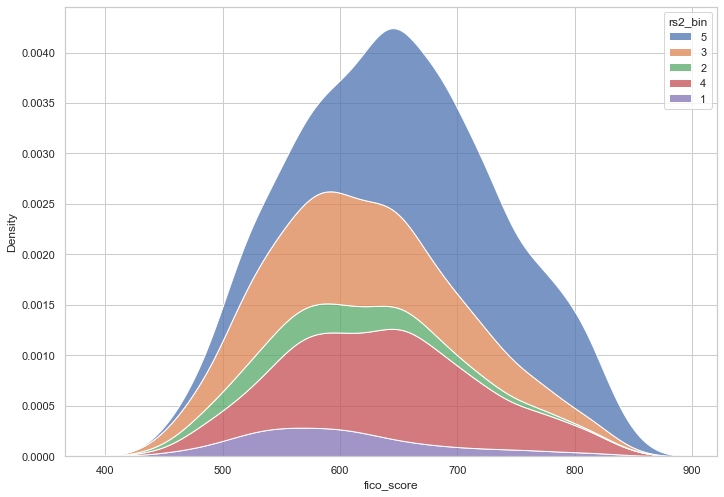

In [26]:
from matplotlib import pyplot
sns.set_style('whitegrid')
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.kdeplot(data=fico_df, x="fico_score", hue="rs2_bin", multiple="stack")

In [27]:
fico_df['month'].value_counts()

1     2896
2     1735
11     424
3      390
12      29
Name: month, dtype: int64

<AxesSubplot:xlabel='fico_score', ylabel='Density'>

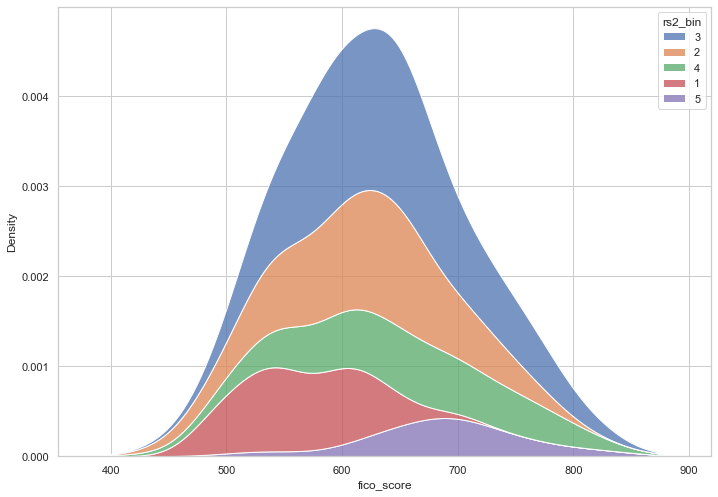

In [28]:
from matplotlib import pyplot
sns.set_style('whitegrid')
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.kdeplot(data=fico_df[fico_df['month'].isin([11,12])], x="fico_score", hue="rs2_bin", multiple="stack")

<AxesSubplot:xlabel='fico_score', ylabel='Density'>

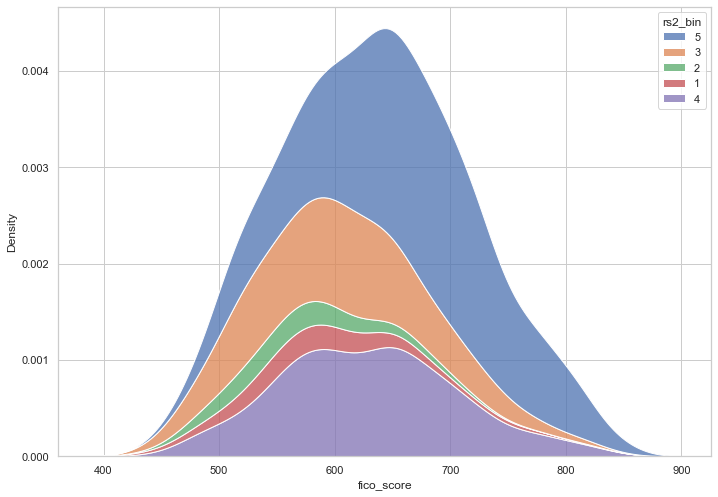

In [29]:
from matplotlib import pyplot
sns.set_style('whitegrid')
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.kdeplot(data=fico_df[fico_df['month'].isin([1])], x="fico_score", hue="rs2_bin", multiple="stack")

<AxesSubplot:xlabel='fico_score', ylabel='Density'>

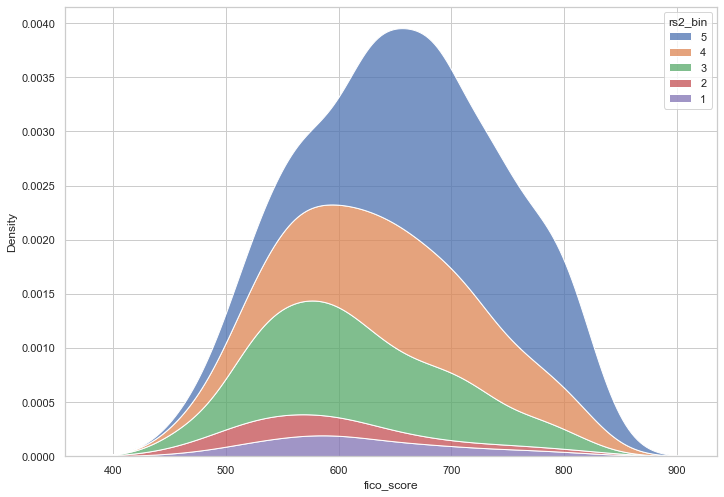

In [30]:
from matplotlib import pyplot
sns.set_style('whitegrid')
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
sns.kdeplot(data=fico_df[fico_df['month'].isin([2])], x="fico_score", hue="rs2_bin", multiple="stack")

In [45]:
#FPD Dollars
doll = querySno(""" 
with min_dates as (
select lending_business_id, min(created_at) as min_created_at, min(due_date) as first_due_date from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LENDING_PAYMENT_SCHEDULES"
group by 1
)

,fpd_flag as 
(
select lending_business_id, sum(total_due_amount) as total_due_amount,
sum(total_payment_received) as total_payment_received, sum(total_exposure) as total_exposure, 
sum(total_interest) as total_interest
from (
select  a.lending_business_id, 
-- case when paid_on_time = 'false' then 1 else 0 end as fpd, 
-- case when month(created_at) = 1 then 'Jan'
-- when month(created_at) = 2 then 'Feb' else 'Other' end as Loan_month,
sum(case when paid_on_time = 'false' then due_amount else 0 end) as total_due_amount,
sum(case when paid_on_time = 'true' then payment else 0 end) as total_payment_received,
sum(principal) as total_exposure,
sum(interest) as total_interest
from "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."LENDING_PAYMENT_SCHEDULES" a 
left join min_dates b on a.lending_business_id = b.lending_business_id
where to_date(b.min_created_at) > to_date('2023-01-02')
and to_date(a.due_date) = to_date(b.first_due_date)
and to_date(b.first_due_date) <= to_date(getdate())
group by 1
)
group by 1
)

, lending_data as (
select 
distinct b.lending_business_id, a.business_id, a.novo_response_score, a.novo_risk_score, a.OFFER_AMOUNT, a.CREATED_AT, a.status, a.reason,a.user_id
,b.novo_risk_score as novo_risk_score2, b.rejection_reasons, b.outcome,predict_meta, c.fico_score
from (select * from 
(select *, row_number() over(partition by business_id order by offer_start_at desc) rnk from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS)
where rnk = 1) a
join
FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_DECISION_RESULTS b 
on a.business_id=json_extract_path_text(b.predict_meta, 'business_id')
left join "FIVETRAN_DB"."PROD_NOVO_API_PUBLIC"."CUSTOMER_CREDIT_PROFILES" c
on a.user_id = c.user_id or b.lending_business_id = c.lending_business_id
where (a.business_id != '' and a.business_id is not null)
)


,bins as (
select lending_data.*,
case 
        when novo_response_score >= 546 then 5
        when novo_response_score >= 405 and novo_response_score < 546 then 4
        when novo_response_score >= 302 and novo_response_score < 405 then 3
        when novo_response_score >= 184 and novo_response_score < 302 then 2
        when novo_response_score < 184 then 1
    else null end as response_bin,
    
    case 
        when novo_risk_score >= 656 then 5
        when novo_risk_score >= 545 and novo_risk_score < 656 then 4
        when novo_risk_score >= 489 and novo_risk_score < 545 then 3
        when novo_risk_score >= 443 and novo_risk_score < 489 then 2
        when novo_risk_score < 443 then 1
    else null end as rs1_bin, 
    json_extract_path_text(predict_meta, 'default_bin') as rs2_bin,
    -- case when fico_score >= 800 then '>800'
    -- when fico_score >= 750 then
    case when fico_score >= 700 then '>700'
    when fico_score >= 650 then '650-700'
    when fico_score >= 600 then '600-650' 
    else '<600' end as fico_bin
    from lending_data
)
--select loan_month,rs2_bin, sum(fpd)/count(*) as fpd_rate ,sum(fpd) as FPD_counts, count(*) as total_accounts from (
select distinct a.lending_business_id, response_bin, rs1_bin, rs2_bin,fico_bin,fico_score,
total_due_amount, total_payment_received, total_exposure, total_interest
from fpd_flag a 
left join bins b 
on a.lending_business_id = b.lending_business_id
--update to remove pilot migrators
join FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS i
on i.business_id = b.business_id
-- where i.segment != 'Pilot migration'
-- )
-- group by 1,2
-- order by 1,2 desc


""")

In [46]:
doll.shape

(887, 10)

In [47]:
doll.head()

,lending_business_id,response_bin,rs1_bin,rs2_bin,fico_bin,fico_score,total_due_amount,total_payment_received,total_exposure,total_interest
0,156e68b2-1fe7-4445-881c-a31e49a7db72,4,5,4,650-700,698,0,15532,13332,2200
1,60f67dd9-6f84-419c-a08c-f83654eb011f,4,5,4,600-650,617,0,28166,21666,6500
2,38c616c6-dd1f-4143-9c94-2365e6c18140,3,5,5,>700,772,0,1816,1666,150
3,7d06b0a9-a230-4e37-9c76-efaced6e5b18,4,5,5,650-700,687,0,52265,46665,5600
4,d86af2ca-b960-4b38-a629-5b5b7b6505f3,3,5,4,<600,None,31193,0,33333,5500


In [51]:
doll['total_exposure'].sum()

86589320

In [53]:
doll['total_due_amount'].sum()/doll['total_exposure'].sum()

0.12132138235985684

In [49]:
len(doll['lending_business_id'].unique())

858

In [69]:
# Response & Approval
resp_df = querySno(r""" 
with lending_data as (
select distinct a.business_id, b.lending_business_id,a.novo_response_score, a.novo_risk_score,b.predict_meta,
case when month(a.offer_start_at) = 1 then 'Jan'
when month(a.offer_start_at) = 2 then 'Feb' else 'Other' end as offer_month,
case when b.lending_business_id is null then 0 else 1 end as response_flag,
case when b.lending_business_id is null or json_extract_path_text(b.outcome,'offer_amount') = 0 then 0 else 1 end as approval_flag
from 
(select * from 
(select *, row_number() over(partition by business_id order by offer_start_at desc) rnk from FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_INVITATIONS)
where rnk = 1) a
left join FIVETRAN_DB.PROD_NOVO_API_PUBLIC.LENDING_DECISION_RESULTS b 
on a.business_id=json_extract_path_text(b.predict_meta, 'business_id')
where (a.business_id != '' and a.business_id is not null)
)
,bins as (
select lending_data.*,
case 
        when novo_response_score >= 546 then 5
        when novo_response_score >= 405 and novo_response_score < 546 then 4
        when novo_response_score >= 302 and novo_response_score < 405 then 3
        when novo_response_score >= 184 and novo_response_score < 302 then 2
        when novo_response_score < 184 then 1
    else null end as response_bin,
    
    case 
        when novo_risk_score >= 656 then 5
        when novo_risk_score >= 545 and novo_risk_score < 656 then 4
        when novo_risk_score >= 489 and novo_risk_score < 545 then 3
        when novo_risk_score >= 443 and novo_risk_score < 489 then 2
        when novo_risk_score < 443 then 1
    else null end as rs1_bin, 
    json_extract_path_text(predict_meta, 'default_bin') as rs2_bin
    from lending_data
)
select * from bins
""")

In [70]:
resp_df.shape

(29928, 11)

In [71]:
resp_df.head()

,business_id,lending_business_id,novo_response_score,novo_risk_score,predict_meta,offer_month,response_flag,approval_flag,response_bin,rs1_bin,rs2_bin
0,3e16122e-5a8e-462c-86cb-154d0621836e,None,465.4070515,911.4078558,None,Feb,0,0,4,5,None
1,b71206e0-2cb0-47c2-9bad-a23385f47124,None,608.9392339,904.9141688,None,Feb,0,0,5,5,None
2,1eed3cb8-5a7e-4fa7-b245-407008b6d8b6,None,443.3888051,692.171679,None,Feb,0,0,4,5,None
3,4dc2e0fd-725e-45bc-ac38-241a035e1974,None,332.610872,896.2780164,None,Feb,0,0,3,5,None
4,e4f1e615-68c8-4cbe-ac3a-a649ebcdc6d3,be37ad87-52cd-4d96-9b90-a3b6e75b263b,646.557992,724.0604258,"{\n ""business_id"": ""e4f1e615-68c8-4cbe-ac3a-a...",Jan,1,1,5,5,3


In [72]:
resp_df[~(resp_df['offer_month']=='Other')].groupby(['response_bin','offer_month'],as_index=False)['response_flag'].agg(['sum','count'])

sum  count
response_bin offer_month             
1            Jan             6      7
2            Feb           387   3115
             Jan             7      8
3            Feb           277   1363
             Jan           544   1364
4            Feb           298   1119
             Jan           755   1574
5            Feb           592   1459
             Jan          1608   2350